--- データ生成開始 ---
読み込み: output2.png (幅: 875, 高さ: 547) -> ラベル: 0
  -> 102枚のデータを生成しました
読み込み: output4.png (幅: 875, 高さ: 547) -> ラベル: 1
  -> 102枚のデータを生成しました
読み込み: output6.png (幅: 875, 高さ: 547) -> ラベル: 2
  -> 102枚のデータを生成しました
読み込み: output8.png (幅: 875, 高さ: 547) -> ラベル: 3
  -> 102枚のデータを生成しました

合計データ数: 408 枚
検出されたクラス数: 4 種類

--- AI学習開始 ---
Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2577 - loss: 1.4187 - val_accuracy: 0.1951 - val_loss: 1.3894
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2761 - loss: 1.3793 - val_accuracy: 0.3780 - val_loss: 1.3711
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2914 - loss: 1.3699 - val_accuracy: 0.3415 - val_loss: 1.3495
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3528 - loss: 1.3091 - val_accuracy: 0.4268 - val_loss: 1.2416
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3681 - loss: 1.2797 - val_accuracy: 0.3902 - val_loss: 1.2204
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━

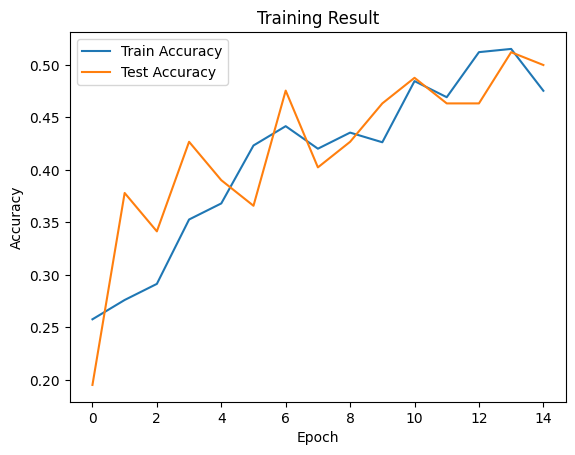

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# ==========================================
# 1. 設定エリア（ここを書き換えてください）
# ==========================================

# 画像ファイル名と、正解ラベルのペアを指定します
# ラベルは 0 から始まる数字で区別してください（例: 0=コンクリート, 1=木材, 2=ガラス...）
# 画像が4つあるなら、以下のようにリストに追加します
image_config = [
    # ("画像ファイルパス", ラベルID)
    ("output2.png", 0),  # 例: アクリル板
    ("output4.png", 1),  # 例: 羊毛マット
    ("output6.png", 2),  # 例: ホワイトボード
    ("output8.png", 3)   # 例: 木製の机
]

# 画像切り出しの設定
WINDOW_WIDTH = 64   # 切り出す幅（ピクセル）
IMG_HEIGHT = 128    # AIに入力する高さ
STRIDE = 8         # ずらす幅（小さいほどデータが大量に増える！重要！）

# ==========================================
# 2. データを切り刻んで作成する関数
# ==========================================
def create_dataset(config):
    X_data = []
    y_label = []

    print("--- データ生成開始 ---")
    for file_path, label in config:
        # 画像読み込み（グレースケール）
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"警告: {file_path} が見つかりません。スキップします。")
            continue
            
        h, w = img.shape
        print(f"読み込み: {file_path} (幅: {w}, 高さ: {h}) -> ラベル: {label}")

        # スライディングウィンドウ処理
        count = 0
        for x in range(0, w - WINDOW_WIDTH, STRIDE):
            # 切り出し
            crop = img[:, x : x + WINDOW_WIDTH]
            # サイズを統一
            crop = cv2.resize(crop, (WINDOW_WIDTH, IMG_HEIGHT))
            
            X_data.append(crop)
            y_label.append(label)
            count += 1
        print(f"  -> {count}枚のデータを生成しました")

    X = np.array(X_data)
    y = np.array(y_label)
    
    # 正規化 (0-255 -> 0.0-1.0) と 次元追加
    X = X.astype('float32') / 255.0
    X = X[..., np.newaxis] # (N, H, W, 1)の形にする
    
    return X, y

# ==========================================
# 3. メイン処理実行
# ==========================================

# --- データセット作成 ---
X, y = create_dataset(image_config)

if len(X) == 0:
    print("エラー: 学習データが作成できませんでした。画像のパスを確認してください。")
    exit()

# クラス数（材質の種類数）を自動計算
num_classes = len(np.unique(y))
print(f"\n合計データ数: {len(X)} 枚")
print(f"検出されたクラス数: {num_classes} 種類")

# --- 学習用とテスト用に分割 (8:2) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- AIモデルの構築 (CNN) ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, WINDOW_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.5), # 過学習防止
    
    Dense(num_classes, activation='softmax') # クラス数に合わせて出力層を自動調整
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 学習開始 ---
print("\n--- AI学習開始 ---")
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# --- 結果表示 ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n==============================")
print(f"最終精度 (Accuracy): {test_acc * 100:.2f}%")
print(f"==============================")

# 学習曲線のグラフ表示（必要なら）
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Result')
plt.show()

--- データ生成開始 ---
読み込み: output_tf2.png (幅: 1189, 高さ: 590) -> ラベル: 0
  -> 113枚のデータを生成しました
読み込み: output_tf4.png (幅: 1189, 高さ: 590) -> ラベル: 1
  -> 113枚のデータを生成しました
読み込み: output_tf6.png (幅: 1189, 高さ: 590) -> ラベル: 2
  -> 113枚のデータを生成しました
読み込み: output_tf8.png (幅: 1189, 高さ: 590) -> ラベル: 3
  -> 113枚のデータを生成しました

合計データ数: 452 枚
検出されたクラス数: 4 種類
学習データ (Train): 270 枚
検証データ (Valid): 91 枚
テストデータ (Test): 91 枚

--- AI学習開始 ---
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2222 - loss: 1.4620 - val_accuracy: 0.2967 - val_loss: 1.3893
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2926 - loss: 1.3774 - val_accuracy: 0.2747 - val_loss: 1.3807
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2333 - loss: 1.4012 - val_accuracy: 0.2967 - val_loss: 1.3862
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2444 - loss: 1.3864 - val_accuracy: 0.3297 - val_loss: 1.3860
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2963 - loss: 1.3855 - val_acc

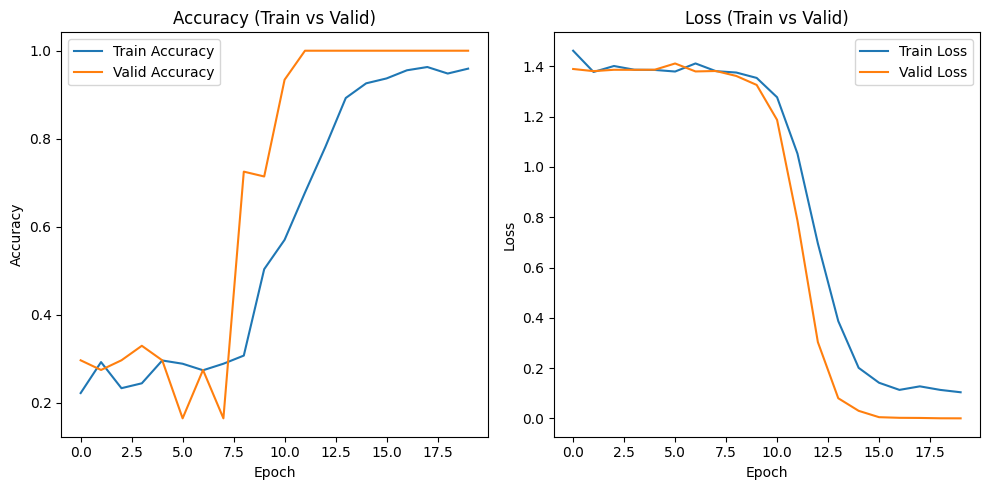

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# ==========================================
# 1. 設定エリア
# ==========================================
image_config = [
    # ("画像ファイルパス", ラベルID)
    # ここに実際のファイルパスを入れてください
    ("output_tf2.png", 0), 
    ("output_tf4.png", 1),
    ("output_tf6.png", 2),
    ("output_tf8.png", 3)
]

WINDOW_WIDTH = 64
IMG_HEIGHT = 128
STRIDE = 10

# ==========================================
# 2. データを切り刻んで作成する関数（変更なし）
# ==========================================
def create_dataset(config):
    X_data = []
    y_label = []

    print("--- データ生成開始 ---")
    for file_path, label in config:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"警告: {file_path} が見つかりません。スキップします。")
            continue
            
        h, w = img.shape
        print(f"読み込み: {file_path} (幅: {w}, 高さ: {h}) -> ラベル: {label}")

        count = 0
        for x in range(0, w - WINDOW_WIDTH, STRIDE):
            crop = img[:, x : x + WINDOW_WIDTH]
            crop = cv2.resize(crop, (WINDOW_WIDTH, IMG_HEIGHT))
            
            X_data.append(crop)
            y_label.append(label)
            count += 1
        print(f"  -> {count}枚のデータを生成しました")

    X = np.array(X_data)
    y = np.array(y_label)
    
    # 正規化と次元追加
    X = X.astype('float32') / 255.0
    X = X[..., np.newaxis]
    
    return X, y

# ==========================================
# 3. メイン処理実行
# ==========================================
# --- データセット作成 ---
X, y = create_dataset(image_config)

if len(X) == 0:
    print("エラー: 学習データが作成できませんでした。画像のパスを確認してください。")
    exit()

num_classes = len(np.unique(y))
print(f"\n合計データ数: {len(X)} 枚")
print(f"検出されたクラス数: {num_classes} 種類")

# ---------------------------------------------------------
# ★変更点: データを3分割 (Train / Valid / Test) する処理
# ---------------------------------------------------------
# 1. まず全体を「学習+検証 (Train+Valid)」と「テスト (Test)」に分ける (Test=20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. 次に「学習+検証」を「学習 (Train)」と「検証 (Valid)」に分ける
# 残りのうち25%をValidにすると、全体から見てちょうど20%になります
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f"学習データ (Train): {len(X_train)} 枚")
print(f"検証データ (Valid): {len(X_val)} 枚")
print(f"テストデータ (Test): {len(X_test)} 枚")

# --- AIモデルの構築 (CNN) ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, WINDOW_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.6),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 学習開始 ---
print("\n--- AI学習開始 ---")
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    # ★変更点: ここで Valid データを使って毎回チェックを行う
    validation_data=(X_val, y_val)
)

# --- 結果表示 ---
# 最後に一度も見ていない Test データで実力を測る
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n==============================")
print(f"最終テスト精度 (Test Accuracy): {test_acc * 100:.2f}%")
print(f"==============================")

# 学習曲線のグラフ表示
plt.figure(figsize=(10, 5))

# Accuracyのグラフ
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy') # Validの推移
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy (Train vs Valid)')

# Lossのグラフ（追加しておきました、過学習の判断に役立ちます）
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss (Train vs Valid)')

plt.tight_layout()
plt.show()